In [1]:
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.optim as optim
import yaml
from torch.nn.parallel import DistributedDataParallel as DDP
import sys, os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributed as dist
import torch.multiprocessing as mp
import torchvision
import torchvision.transforms as transforms
from torch.nn.parallel import DistributedDataParallel
from torch.utils.data import Dataset
import torch.optim as optim
# root_dir = '/mnt/home/spandey/ceph/CHARM/'
# os.chdir(root_dir)
import pickle as pk
import pathlib
curr_path = pathlib.Path().absolute()
src_path = os.path.abspath(curr_path / "../charm/") 
sys.path.append(src_path)
# sys.path.append(root_dir)
# from combined_models import *
# from all_models import *
from charm import *
from utils_data_prep_cosmo_vel import *
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 67.11, 'Om0': 0.3175, 'Ob0': 0.049, 'sigma8': 0.834, 'ns': 0.9624}
cosmo = cosmology.setCosmology('myCosmo', **params)
from colossus.lss import mass_function
from tqdm import tqdm
import sparse
import numpy as np
import h5py as h5
import torch
from torch.nn import functional as F
from dataclasses import dataclass
from contextlib import nullcontext
from dataclasses import dataclass
from torch.nn.parallel import DistributedDataParallel as DDP
import matplotlib.pyplot as pl

import os
%load_ext autoreload
%autoreload 2
%matplotlib inline




In [2]:
test_id = 1611






In [3]:
# run_config_name = 'TRAIN_MASS_FREECOSMO_cond_fastpm_ns128.yaml'
run_config_name = 'TRAIN_MASS_FREECOSMO_cond_fastpm_ns128_lresdata.yaml'
with open("/mnt/home/spandey/ceph/CHARM/run_configs/" + run_config_name,"r") as file_object:
    config=yaml.load(file_object,Loader=yaml.SafeLoader)


config_sims = config['sim_settings']
ji_array = np.arange(int(config_sims['nsims']))
nsubvol_per_ji = int(config_sims['nsubvol_per_ji'])
nsubvol_fid = int(config_sims['nsubvol_fid'])
subsel_criteria = config_sims['subsel_criteria']
num_cosmo_params = int(config_sims['num_cosmo_params'])
ns_d = config_sims['ns_d']
nb = config_sims['nb']
nax_d =  ns_d // nb
nf = config_sims['nf']
layers_types = config_sims['layers_types']
z_inference = config_sims['z_inference']
nc = 0
for jl in range(len(layers_types)):
    if layers_types[jl] == 'cnn':
        nc += 1
    elif layers_types[jl] == 'res':
        nc += 2
    else:
        raise ValueError("layer type not supported")

z_all = config_sims['z_all']
z_all_FP = config_sims['z_all_FP']
# z_all_FP = z_all_FP[:-1]
z_all_FP = z_all_FP
ns_h = config_sims['ns_h']
nax_h = ns_h // nb
cond_sim = config_sims['cond_sim']

nsims_per_batch = config_sims['nsims_per_batch']
nbatches_train = config_sims['nbatches_train']

mass_type = config_sims['mass_type']
lgMmin = config_sims['lgMmin']
lgMmax = config_sims['lgMmax']
stype = config_sims['stype']
rescale_sub = config_sims['rescale_sub']
lgMmincutstr = config_sims['lgMmincutstr']
# subsel_highM1 = config_sims['subsel_highM1']
# nsubsel = config_sims['nsubsel']
is_HR = config_sims['is_HR']

try:
    Nmax = config_sims['Nmax']
except:
    Nmax = 4

config_net = config['network_settings']
hidden_dim_MAF = config_net['hidden_dim_MAF']
learning_rate = config_net['learning_rate']
K_M1 = config_net['K_M1']
B_M1 = config_net['B_M1']
nflows_M1_NSF = config_net['nflows_M1_NSF']

K_Mdiff = config_net['K_Mdiff']
B_Mdiff = config_net['B_Mdiff']
nflows_Mdiff_NSF = config_net['nflows_Mdiff_NSF']

base_dist_Ntot = config_net['base_dist_Ntot']
if base_dist_Ntot == 'None':
    base_dist_Ntot = None
base_dist_M1 = config_net['base_dist_M1']
base_dist_Mdiff = config_net['base_dist_Mdiff']
ngauss_M1 = config_net['ngauss_M1']

changelr = config_net['changelr']
ksize = nf
nfeature_cnn = config_net['nfeature_cnn']
nout_cnn = 4 * nfeature_cnn
if cond_sim == 'fastpm':
    if any('v' in str(string) for string in z_all_FP):
        ninp = len(z_all_FP) + 2
    else:
        ninp = len(z_all_FP)

elif cond_sim == 'quijote':
    ninp = len(z_all)
else:
    raise ValueError("cond_sim not supported")

num_cond = nout_cnn + ninp + num_cosmo_params


device_id = torch.device("cuda")
ndim_diff = Nmax - 1

lgM_array = np.linspace(lgMmin, lgMmax, 1000)
M_array = 10**lgM_array
if '200c' in mass_type:
    hmf = mass_function.massFunction(M_array, float(z_inference), mdef = '200c', model = 'tinker08', q_out = 'dndlnM')
if 'vir' in mass_type:
    hmf = mass_function.massFunction(M_array, float(z_inference), mdef = 'vir', model = 'tinker08', q_out = 'dndlnM')    
if 'fof' in mass_type:
    hmf = mass_function.massFunction(M_array, float(z_inference), mdef = 'fof', model = 'bhattacharya11', q_out = 'dndlnM')
lgM_rescaled = rescale_sub + (lgM_array - lgMmin)/(lgMmax-lgMmin)

int_val = sp.integrate.simps(hmf, lgM_rescaled)
hmf_pdf = hmf/int_val
# define the cdf of the halo mass function
hmf_cdf = np.zeros_like(hmf_pdf)
for i in range(len(hmf_cdf)):
    hmf_cdf[i] = sp.integrate.simps(hmf_pdf[:i+1], lgM_rescaled[:i+1])

if 'sigv' in config:
    sigv = config['sigv']
else:
    sigv = 0.05
num_cond_Ntot = num_cond
mu_all = np.arange(Nmax + 1) + 1
sig_all = sigv * np.ones_like(mu_all)
ngauss_Nhalo = Nmax + 1

model_BinaryMask = SumGaussModel(
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_Ntot,
    ngauss=2,
    mu_all=mu_all[:2],
    sig_all=sig_all[:2],
    base_dist=base_dist_Ntot,
    device=device_id
    )

# model_BinaryMask.to(dev)


model_multiclass = SumGaussModel(
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_Ntot,
    ngauss=ngauss_Nhalo - 1,
    mu_all=mu_all[1:] - 1,
    sig_all=sig_all[1:],
    base_dist=base_dist_Ntot,
    device=device_id
    )


# model_multiclass.to(dev)


num_cond_M1 = num_cond + 1
# # if conditioned on fastpm we will also give the fastpm fof M1 halos and its mask as conditional
# if cond_sim == 'fastpm':
#     num_cond_M1 += 2

model_M1 = NSF_1var_CNNcond(
    K=K_M1,
    B=B_M1,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_M1,
    nflows=nflows_M1_NSF,
    base_dist=base_dist_M1,
    ngauss=ngauss_M1,
    lgM_rs_tointerp=lgM_rescaled,
    hmf_pdf_tointerp=hmf_pdf,
    hmf_cdf_tointerp=hmf_cdf,
    device=device_id 
    )

ndim_diff = Nmax - 1
num_cond_Mdiff = num_cond + 2
model_Mdiff = NSF_Autoreg_CNNcond(
    dim=ndim_diff,
    K=K_Mdiff,
    B=B_Mdiff,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_Mdiff,
    nflows=nflows_Mdiff_NSF,
    base_dist=base_dist_Mdiff,
    mu_pos=True
    )


ndim = ndim_diff + 1
model = COMBINED_Model(
    None,
    model_Mdiff,
    # None,
    model_M1,
    model_BinaryMask,
    model_multiclass,
    ndim,
    ksize,
    ns_d,
    ns_h,
    1,
    ninp,
    nfeature_cnn,
    nout_cnn,
    layers_types=layers_types,
    act='tanh',
    padding='valid',
    sep_Binary_cond=True,
    sep_MultiClass_cond=True,
    sep_M1_cond=True,
    sep_Mdiff_cond=True,
    num_cond_Binary = num_cond_Ntot,
    num_cond_MultiClass = num_cond_Ntot,
    num_cond_M1 = num_cond_M1,
    num_cond_Mdiff = num_cond_Mdiff
    ).to(device_id)

# model = DDP(model, device_ids=[device_id], find_unused_parameters=True)

model = torch.nn.DataParallel(model)


ldir_cp = '/mnt/home/spandey/ceph/CHARM/model_checkpoints/test0/'

checkpoint = torch.load(ldir_cp + f'test_model_bestfit_6484.pth', map_location=device_id)
# print(iter)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
print()



ldir_f = '/mnt/home/spandey/ceph/Quijote/data_NGP_self_fastpm_LH/'

n_dim_red = (nf - 1) // 2
n_pad = n_dim_red * nc

df_zg = pk.load(open(ldir_f + '%d/density_HR_full_m_res_128_z=0.5_nbatch_8_nfilter_3_ncnn_0.pk'%test_id,'rb'))
df_test_zg = df_zg['density_cic_unpad_combined']
df_test_pad_zg = np.pad(df_test_zg, n_pad, 'wrap')



z_REDSHIFT = float(z_all_FP[-1].split('_')[1])
if z_REDSHIFT == 0.0:
    z_REDSHIFT = 0

df_load = pk.load(open(
    ldir_f + '/' + str(test_id) + '/velocity_HR_full_m_res_128_z=' + str(z_REDSHIFT) + '_nbatch_8_nfilter_3_ncnn_0.pk', 'rb')
    )

vel_all = df_load['velocity_cic_unpad_combined']
# # vel_pad_all = 
vel_pad = np.stack([np.pad(vel_all[j,...], n_pad, 'wrap') for j in range(3)], axis=0)

df_test_all_pad = np.concatenate([np.log(1 + df_test_pad_zg + 1e-10)[None,...], vel_pad], axis=0)[None, None,:]
# df_test_all_pad = np.stack([np.log(1 + df_test_pad_zg + 1e-10), np.log(
#     1 + df_test_pad_zIC + 1e-10), df_test_pad_constrast_zg], axis=0)[None, None, :]

# df_test_all_pad.shape

# density_smoothed = gaussian_filter(df_test_zg, sigma=VALUE_SIG)
# df_test_constrast_zg = density_smoothed - df_test_zg
# 
df_test_all_unpad = np.concatenate([np.log(1 + df_test_zg + 1e-10)[None,...], vel_all], axis=0)[None, None,:]
# df_test_all_unpad = np.stack([np.log(1 + df_test_zg + 1e-10), np.log(
#     1 + df_test_zIC + 1e-10), df_test_constrast_zg], axis=0)[None, None, :]

# df_test_all_unpad.shape

cond_nsh_test = np.moveaxis(df_test_all_unpad, 2, 5)
nsims_test = cond_nsh_test.shape[1]
nax_h_test = cond_nsh_test.shape[2]
ninp_test = cond_nsh_test.shape[-1]
cond_tensor_nsh_test = torch.Tensor(np.copy(cond_nsh_test.reshape(1,nsims_test * (nax_h_test ** 3), ninp_test))).cuda(device_id)    

# cond_tensor_nsh_test.shape
LH_cosmo_val_file='/mnt/home/spandey/ceph/Quijote/latin_hypercube_params.txt'
LH_cosmo_val_all = np.loadtxt(LH_cosmo_val_file)
fid_cosmo_val_all = LH_cosmo_val_all[test_id]
# fid_cosmo_val_all = np.array([0.3175, 0.049, 0.6711, 0.9624, 0.64])  

cosmo_val_test = np.tile(fid_cosmo_val_all, (cond_tensor_nsh_test.shape[1] ,1))[None,:]

# cosmo_val_test.shape
# df_test_all_pad.shape, df_test_all_unpad.shape, cosmo_val_test.shape
df_test_all_pad = torch.tensor(df_test_all_pad).to(device_id)
df_test_all_unpad = torch.tensor(cond_tensor_nsh_test).to(device_id)
cosmo_val_test = torch.tensor(cosmo_val_test, dtype=torch.float32).to(device_id)


train_Ntot, train_M1, train_Mdiff = 1, 1, 1
train_binary, train_multi = 1, 1
# if verbose:
    # print(f"Running the model")

# run the model
Ntot_samp_test, M1_samp_test, M_diff_samp_test, mask_tensor_M1_samp_test, mask_tensor_Mdiff_samp_test, _ = model.module.inverse(
    cond_x=df_test_all_pad,
    cond_x_nsh=df_test_all_unpad,
    cond_cosmo=cosmo_val_test,
    use_truth_Nhalo=1-train_Ntot,
    use_truth_M1=1-train_M1,
    use_truth_Mdiff=1-train_Mdiff,
    mask_Mdiff_truth=None,
    mask_M1_truth=None,
    Nhalos_truth=None,
    M1_truth=None,
    Mdiff_truth=None,
    train_binary=train_binary,
    train_multi=train_multi,
    train_M1=train_M1,
    train_Mdiff=train_Mdiff,
)


BoxSize=1000
# Ntot_samp_test[0].shape
Ntot_samp_test_rs = Ntot_samp_test[0][:, np.newaxis]
M1_samp_test_rs = (M1_samp_test[0] * mask_tensor_M1_samp_test[0][:, 0]).cpu().detach().numpy()
M_diff_samp_test_rs = (M_diff_samp_test[0] * mask_tensor_Mdiff_samp_test[0]).cpu().detach().numpy()




Ntot_samp_test = Ntot_samp_test[0][:, np.newaxis]
save_subvol_Nhalo = Ntot_samp_test.reshape(
    nsims_test, nax_h_test, nax_h_test, nax_h_test)
save_subvol_M1 = (M1_samp_test[0] * mask_tensor_M1_samp_test[0][:, 0]
                    ).cpu().detach().numpy().reshape(nsims_test, nax_h_test, nax_h_test, nax_h_test, 1)
save_subvol_Mdiff = (M_diff_samp_test[0] * mask_tensor_Mdiff_samp_test[0]
                        ).cpu().detach().numpy().reshape(nsims_test, nax_h_test, nax_h_test, nax_h_test, ndim_diff)

mask_subvol_Mtot1 = mask_tensor_M1_samp_test[0].cpu().detach().numpy().reshape(
    nsims_test, nax_h_test, nax_h_test, nax_h_test)[..., None]
mask_subvol_Mtot2 = mask_tensor_Mdiff_samp_test[0].cpu().detach().numpy(
).reshape(nsims_test, nax_h_test, nax_h_test, nax_h_test, ndim_diff)
mask_subvol_Mtot = np.concatenate(
    [mask_subvol_Mtot1, mask_subvol_Mtot2], axis=-1)

# compute the mass of halos from output
save_subvol_Mtot = np.zeros(
    (nsims_test, nax_h_test, nax_h_test, nax_h_test, ndim_diff + 1))
# Mmin, Mmax = return_dict_test['Mmin'], return_dict_test['Mmax']
for jd in range(ndim_diff + 1):
    if jd == 0:
        save_subvol_Mtot[..., jd] = (
            save_subvol_M1[..., 0] + 0.5) * (lgMmax - lgMmin) + lgMmin
    else:
        save_subvol_Mtot[...,
                            jd] = (save_subvol_Mtot[..., jd - 1]) - (save_subvol_Mdiff[..., jd - 1]) * (lgMmax - lgMmin)

save_subvol_Mtot *= mask_subvol_Mtot

Nhalos = save_subvol_Nhalo[0, ...]  # histogram of halos in each voxel
M_halos = save_subvol_Mtot[0, ...]  # mass of halos in each voxel
M_halos_sort_norm = rescale_sub + (M_halos - lgMmin)/(lgMmax - lgMmin)
M_halos_sort_norm *= mask_subvol_Mtot[0, ...]
M_halos_sort_norm_condvel = M_halos_sort_norm.reshape(nax_h_test**3, -1)
# create the meshgrid
xall = (np.linspace(0, BoxSize, ns_h + 1))
xarray = 0.5 * (xall[1:] + xall[:-1])
yarray = np.copy(xarray)
zarray = np.copy(xarray)
x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')

# record discrete halo positions and masses
x_h_mock, y_h_mock, z_h_mock, lgM_mock = [], [], [], []
# Nmax_sel = 3
k = 0
for jx in range(ns_h):
    for jy in range(ns_h):
        for jz in range(ns_h):
            Nh_vox = int(Nhalos[jx, jy, jz])
            if Nh_vox > 0:
                x_h_mock.append(x_cy[jx, jy, jz]*np.ones(Nh_vox))
                y_h_mock.append(y_cy[jx, jy, jz]*np.ones(Nh_vox))
                z_h_mock.append(z_cy[jx, jy, jz]*np.ones(Nh_vox))

                lgM_mock.append((M_halos[jx, jy, jz, :Nh_vox]))
                k += Nh_vox

# convert to numpy arrays
x_h_mock = np.concatenate(x_h_mock)
y_h_mock = np.concatenate(y_h_mock)
z_h_mock = np.concatenate(z_h_mock)
pos_h_mock = np.vstack((x_h_mock, y_h_mock, z_h_mock)).T
lgMass_mock = np.concatenate(lgM_mock)
# convert to float data type
pos_h_mock = pos_h_mock.astype('float32')
lgMass_mock = lgMass_mock.astype('float32')



isim = test_id
# snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/fiducial_HR'
snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/latin_hypercube_HR'
snapnum = 3
MAS     = 'NGP'  #mass-assigment scheme
verbose = False   #print information on progress
snapdir = snap_dir_base + '/' + str(isim)  #folder hosting the catalogue
rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
    lines = f.readlines()
header = lines[0].split()
# get the properties of the halos
pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
index_M = header.index('M200c')                    
mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
lgMass_truth = np.log10(mass_truth).astype(np.float32)
vel_h_truth = rockstar[:,header.index('VX'):header.index('VZ')+1]

indsel = np.where(mass_truth > 5e12)[0]
pos_h_truth = pos_h_truth[indsel]
vel_h_truth = vel_h_truth[indsel]
lgMass_truth = lgMass_truth[indsel]


# saved = {'pos_h_mock': pos_h_mock, 'lgMass_mock': lgMass_mock, 'pos_h_truth': pos_h_truth, 
#         'lgMass_truth': lgMass_truth, 'vel_h_truth': vel_h_truth,
#         'Ntot_samp_test_rs':Ntot_samp_test_rs,
#         'M_halos_sort_norm_condvel':M_halos_sort_norm_condvel,
#         'df_test_all_pad':df_test_all_pad,
#         'df_test_all_unpad':df_test_all_unpad,
#         'cosmo_val_test':cosmo_val_test}
# pk.dump(saved, open(f'mock_true_data_LH_{test_id}.pk', 'wb'))






/tmp/ipykernel_3923246/1064488005.py:103: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  int_val = sp.integrate.simps(hmf, lgM_rescaled)
/tmp/ipykernel_3923246/1064488005.py:108: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  hmf_cdf[i] = sp.integrate.simps(hmf_pdf[:i+1], lgM_rescaled[:i+1])


/tmp/ipykernel_3923246/1064488005.py:278: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  df_test_all_unpad = torch.tensor(cond_tensor_nsh_test).to(device_id)
/tmp/ipykernel_3923246/1064488005.py:400: RuntimeWarning: divide by zero encountered in log10
  lgMass_truth = np.log10(mass_truth).astype(np.float32)


In [1]:
cosmo_val_test


NameError: name 'cosmo_val_test' is not defined

Text(0.5, 1.0, 'Real Pk, LH=130')

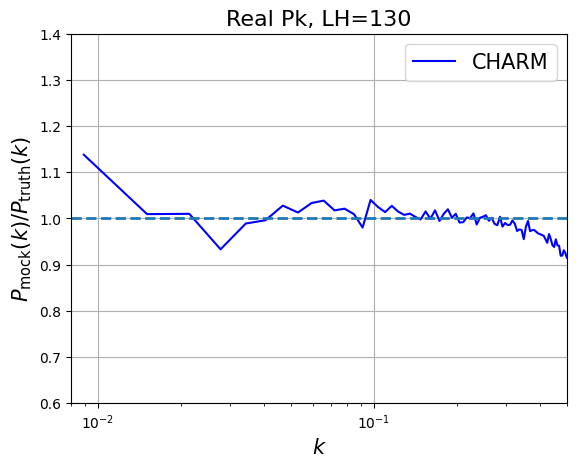

In [39]:
import Pk_library as PKL
import MAS_library as MASL
grid_Pk_full = 128
MAS = 'NGP'
threads = 10
mesh_orig = np.zeros((grid_Pk_full, grid_Pk_full, grid_Pk_full), dtype=np.float32)
MASL.MA(pos_h_truth.astype(np.float32), mesh_orig, 1000., MAS)
mesh_orig /= np.mean(mesh_orig, dtype=np.float64);  mesh_orig -= 1.0
Pk_orig_real = PKL.Pk(mesh_orig, 1000., axis=0, MAS=MAS, threads=threads, verbose=False)

mesh_charm = np.zeros((grid_Pk_full, grid_Pk_full, grid_Pk_full), dtype=np.float32)
MASL.MA(pos_h_mock.astype(np.float32), mesh_charm, 1000., MAS)
mesh_charm /= np.mean(mesh_charm, dtype=np.float64);  mesh_charm -= 1.0
Pk_charm_real = PKL.Pk(mesh_charm, 1000., axis=0, MAS=MAS, threads=threads, verbose=False)

pl.figure()
# pl.plot(Pk_orig_rsd.k3D, Pk_pm_rsd.Pk[:,0]/Pk_orig_rsd.Pk[:,0], color='k', ls='-', alpha=1.0, label='FastPM')
pl.plot(Pk_orig_real.k3D, Pk_charm_real.Pk[:,0]/Pk_orig_real.Pk[:,0], color='b', ls='-', alpha=1.0, label='CHARM')
pl.axhline(1.0, ls='--', lw=2.0)
pl.xscale('log')
pl.ylim(0.6, 1.4)
pl.xlim(0.008, 0.5)
pl.xlabel(r'$k$', size=15)
pl.grid()
pl.legend(fontsize=15)
pl.ylabel(r'$P_{\rm mock}(k)/P_{\rm truth}(k)$', size=15)
pl.title(f'Real Pk, LH={test_id}', size=16)
# pl.savefig(sdirf + '/mono/' + f'NEW_monopole_Pk_{iter}.png', dpi=300,bbox_inches='tight')





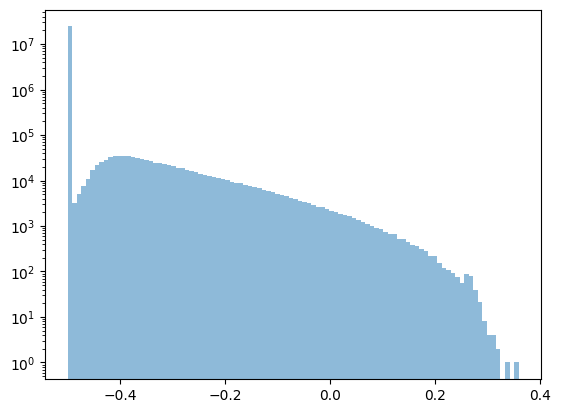

In [40]:
indsel = np.where(M_halos_sort_norm_condvel < -0.5)
M_halos_sort_norm_condvel[indsel] = -0.5
indsel = np.where(M_halos_sort_norm_condvel == 0.0)
M_halos_sort_norm_condvel[indsel] = -0.5

pl.figure()
_ = pl.hist(M_halos_sort_norm_condvel.flatten(), bins=100, alpha=0.5, label='Mhalos_truth_tensor') 
pl.yscale('log')



In [4]:
# saved = pk.load(open(f'mock_true_data_LH_{test_id}.pk', 'rb'))
# pos_h_mock = saved['pos_h_mock']
# lgMass_mock = saved['lgMass_mock']
# pos_h_truth = saved['pos_h_truth']
# lgMass_truth = saved['lgMass_truth']
# vel_h_truth = saved['vel_h_truth']
# df_test_all_pad = saved['df_test_all_pad']
# df_test_all_unpad = saved['df_test_all_unpad']
# cosmo_val_test = saved['cosmo_val_test']
# Ntot_samp_test_rs = saved['Ntot_samp_test_rs']
# M_halos_sort_norm_condvel = saved['M_halos_sort_norm_condvel']
# indsel = np.where(M_halos_sort_norm_condvel < -0.5)
# M_halos_sort_norm_condvel[indsel] = -0.5
# indsel = np.where(M_halos_sort_norm_condvel = 0.0)
# M_halos_sort_norm_condvel[indsel] = -0.5

run_config_name = 'TRAIN_VEL_FREECOSMO_cond_fastpm_ns128_lresdata.yaml'
with open("/mnt/home/spandey/ceph/CHARM/run_configs/" + run_config_name,"r") as file_object:
    config=yaml.load(file_object,Loader=yaml.SafeLoader)


config_sims = config['sim_settings']
ji_array = np.arange(int(config_sims['nsims']))
nsubvol_per_ji = int(config_sims['nsubvol_per_ji'])
nsubvol_fid = int(config_sims['nsubvol_fid'])
subsel_criteria = config_sims['subsel_criteria']
num_cosmo_params = int(config_sims['num_cosmo_params'])
ns_d = config_sims['ns_d']
nb = config_sims['nb']
nax_d =  ns_d // nb
nf = config_sims['nf']
layers_types = config_sims['layers_types']
z_inference = config_sims['z_inference']
nc = 0
for jl in range(len(layers_types)):
    if layers_types[jl] == 'cnn':
        nc += 1
    elif layers_types[jl] == 'res':
        nc += 2
    else:
        raise ValueError("layer type not supported")

z_all = config_sims['z_all']
z_all_FP = config_sims['z_all_FP']
# z_all_FP = z_all_FP[:-1]
z_all_FP = z_all_FP
ns_h = config_sims['ns_h']
nax_h = ns_h // nb
cond_sim = config_sims['cond_sim']

nsims_per_batch = config_sims['nsims_per_batch']
nbatches_train = config_sims['nbatches_train']

mass_type = config_sims['mass_type']
lgMmin = config_sims['lgMmin']
lgMmax = config_sims['lgMmax']
stype = config_sims['stype']
rescale_sub = config_sims['rescale_sub']
lgMmincutstr = config_sims['lgMmincutstr']
# subsel_highM1 = config_sims['subsel_highM1']
# nsubsel = config_sims['nsubsel']
is_HR = config_sims['is_HR']

try:
    Nmax = config_sims['Nmax']
except:
    Nmax = 4

config_net = config['network_settings']
hidden_dim_MAF = config_net['hidden_dim_MAF']
learning_rate = config_net['learning_rate']
# K_M1 = config_net['K_M1']
# B_M1 = config_net['B_M1']
# nflows_M1_NSF = config_net['nflows_M1_NSF']

K_vel = config_net['K_vel']
B_vel = config_net['B_vel']
nflows_vel_NSF = config_net['nflows_vel_NSF']
cond_Mass_for_vel = config_net['cond_Mass_for_vel']
# base_dist_Ntot = config_net['base_dist_Ntot']
# if base_dist_Ntot == 'None':
#     base_dist_Ntot = None
# base_dist_M1 = config_net['base_dist_M1']
base_dist_vel = config_net['base_dist_vel']
# ngauss_M1 = config_net['ngauss_M1']

changelr = config_net['changelr']
ksize = nf
nfeature_cnn = config_net['nfeature_cnn']
nout_cnn = 4 * nfeature_cnn
if cond_sim == 'fastpm':
    if any('v' in str(string) for string in z_all_FP):
        ninp = len(z_all_FP) + 2
    else:
        ninp = len(z_all_FP)

elif cond_sim == 'quijote':
    ninp = len(z_all)
else:
    raise ValueError("cond_sim not supported")

num_cond = nout_cnn + ninp + num_cosmo_params


device_id = torch.device("cuda")
ndim_diff = Nmax - 1
ndim_mass = Nmax
ndim_vel = 3*Nmax

lgM_array = np.linspace(lgMmin, lgMmax, 1000)
M_array = 10**lgM_array
if '200c' in mass_type:
    hmf = mass_function.massFunction(M_array, float(z_inference), mdef = '200c', model = 'tinker08', q_out = 'dndlnM')
if 'vir' in mass_type:
    hmf = mass_function.massFunction(M_array, float(z_inference), mdef = 'vir', model = 'tinker08', q_out = 'dndlnM')    
if 'fof' in mass_type:
    hmf = mass_function.massFunction(M_array, float(z_inference), mdef = 'fof', model = 'bhattacharya11', q_out = 'dndlnM')
lgM_rescaled = rescale_sub + (lgM_array - lgMmin)/(lgMmax-lgMmin)

int_val = sp.integrate.simps(hmf, lgM_rescaled)
hmf_pdf = hmf/int_val
# define the cdf of the halo mass function
hmf_cdf = np.zeros_like(hmf_pdf)
for i in range(len(hmf_cdf)):
    hmf_cdf[i] = sp.integrate.simps(hmf_pdf[:i+1], lgM_rescaled[:i+1])

if 'sigv' in config:
    sigv = config['sigv']
else:
    sigv = 0.05
    
if cond_Mass_for_vel:
    num_cond_vel = num_cond + ndim_mass
else:
    num_cond_vel = num_cond
    
model_vel = NSF_Autoreg_CNNcond(
    dim=ndim_vel,
    K=K_vel,
    B=B_vel,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_vel,
    nflows=nflows_vel_NSF,
    base_dist=base_dist_vel,
    mu_pos=False
    )


# ndim = ndim_diff + 1
model = COMBINED_Model_vel_only(
    None,
    model_vel,
    ndim_vel,
    ksize,
    ns_d,
    ns_h,
    1,
    ninp,
    nfeature_cnn,
    nout_cnn,
    layers_types=layers_types,
    act='tanh',
    padding='valid',
    ).to(device_id)

# model = DDP(model, device_ids=[device_id], find_unused_parameters=True)

model = torch.nn.DataParallel(model)

ldir_cp = '/mnt/home/spandey/ceph/CHARM/model_checkpoints/test2_vel/'
# ldir_cp = '/mnt/home/spandey/ceph/CHARM/model_checkpoints/test0_vel/'

# checkpoint = torch.load(ldir_cp + f'test_model_bestfit_6600.pth', map_location=device_id)
# checkpoint = torch.load(ldir_cp + f'test_model_bestfit_4800_moredata.pth', map_location=device_id)
# checkpoint = torch.load(ldir_cp + f'test_model_bestfit_1000_evenmoredata_nsub11k.pth', map_location=device_id)
checkpoint = torch.load(ldir_cp + f'test_model_bestfit_5600_evenmoredata_nsub11k.pth', map_location=device_id)
# print(iter)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
print()




/tmp/ipykernel_3923246/641660123.py:120: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  int_val = sp.integrate.simps(hmf, lgM_rescaled)
/tmp/ipykernel_3923246/641660123.py:125: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  hmf_cdf[i] = sp.integrate.simps(hmf_pdf[:i+1], lgM_rescaled[:i+1])


In [5]:
# # checkpoint.keys()
# ldir_cp = '/mnt/home/spandey/ceph/CHARM/model_checkpoints/test2_vel/'
# # ldir_cp = '/mnt/home/spandey/ceph/CHARM/model_checkpoints/test0_vel/'

# # checkpoint = torch.load(ldir_cp + f'test_model_bestfit_6900.pth', map_location=device_id)
# # checkpoint = torch.load(ldir_cp + f'test_model_bestfit_4700_moredata.pth', map_location=device_id)
# checkpoint = torch.load(ldir_cp + f'test_model_bestfit_100_evenmoredata_nsub11k.pth', map_location=device_id)

# checkpoint['loss_min']




In [6]:
df_test_all_pad = torch.tensor(df_test_all_pad).cuda(device_id)
df_test_all_unpad = torch.tensor(df_test_all_unpad).cuda(device_id)
cosmo_val_test = torch.tensor(cosmo_val_test, dtype=torch.float32).cuda(device_id)
Nhalos_truth_recomb_tensor = torch.Tensor(Ntot_samp_test_rs[None,...]).cuda(device_id)
if cond_Mass_for_vel:
    Mhalos_truth_recomb_tensor = torch.Tensor(M_halos_sort_norm_condvel[None,...]).cuda(device_id)
else:
    Mhalos_truth_recomb_tensor = None




/tmp/ipykernel_3923246/3666363080.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  df_test_all_pad = torch.tensor(df_test_all_pad).cuda(device_id)
/tmp/ipykernel_3923246/3666363080.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  df_test_all_unpad = torch.tensor(df_test_all_unpad).cuda(device_id)
/tmp/ipykernel_3923246/3666363080.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cosmo_val_test = torch.tensor(cosmo_val_test, dtype=torch.float32).cuda(device_id)


In [7]:
# pl.figure()
# _ = pl.hist(Mhalos_truth_recomb_tensor.cpu().numpy().flatten(), bins=100, alpha=0.5, label='Mhalos_truth_tensor', range=(-0.5, 0.5)) 
# pl.yscale('log')




In [8]:
# Nhalos_truth_recomb_tensor.shape, Mhalos_truth_recomb_tensor.shape
torch.cuda.empty_cache()



In [9]:
vel_samp_out = model.module.inverse(cond_x=df_test_all_pad,
                            cond_x_nsh=df_test_all_unpad,
                            cond_cosmo=cosmo_val_test,
                            mask_vel_truth=None,
                            Nhalos_truth=Nhalos_truth_recomb_tensor,
                            Mhalos_truth=Mhalos_truth_recomb_tensor,
                            # Mhalos_truth=None,                            
                            vel_truth=None)




In [10]:
import pickle as pk
from scipy.interpolate import RegularGridInterpolator
grid = 128
BoxSize = 1000.
xall = (np.linspace(0, BoxSize, grid + 1))
xarray = 0.5 * (xall[1:] + xall[:-1])
yarray = np.copy(xarray)
zarray = np.copy(xarray)

# vel_load_dir = '/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm/'
vel_load_dir = '/mnt/home/spandey/ceph/Quijote/data_NGP_self_fastpm_LH/'
df = pk.load(open(vel_load_dir + f'{test_id}/velocity_HR_full_m_res_128_z=0.5_nbatch_8_nfilter_3_ncnn_0.pk', 'rb'))['velocity_cic_unpad_combined']
# df.shape
vx_mesh_load = 1000.*df[0,...]
vy_mesh_load = 1000.*df[1,...]
vz_mesh_load = 1000.*df[2,...]

vx_all_3D_interp_l = RegularGridInterpolator((xarray, yarray, zarray), vx_mesh_load, bounds_error=False, fill_value=None)
vy_all_3D_interp_l = RegularGridInterpolator((xarray, yarray, zarray), vy_mesh_load, bounds_error=False, fill_value=None)
vz_all_3D_interp_l = RegularGridInterpolator((xarray, yarray, zarray), vz_mesh_load, bounds_error=False, fill_value=None)

vx_eval_interp_l = vx_all_3D_interp_l(pos_h_mock)
vy_eval_interp_l = vy_all_3D_interp_l(pos_h_mock)
vz_eval_interp_l = vz_all_3D_interp_l(pos_h_mock)




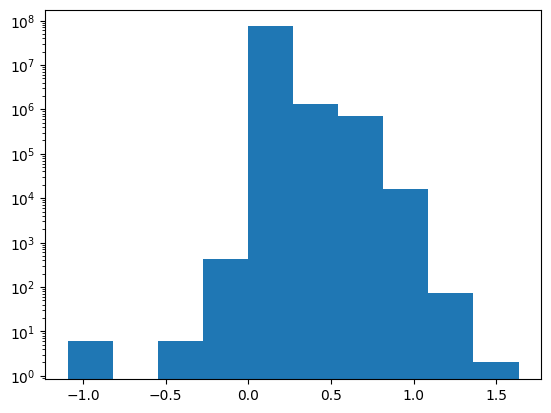

In [11]:
pl.figure()
_ = pl.hist(vel_samp_out.flatten())
pl.yscale('log')





In [12]:
vmax = 1000
vmin = -1000
jsim = test_id
ndim_diff = Nmax - 1
sdir_fid='/mnt/home/spandey/ceph/Quijote/data_NGP_self_LH'
mass_type = 'rockstar_200c'
# try:
fname = sdir_fid + '/' + str(jsim) + '/SPARSEMATS_halos_HR_rockstar_200c_lgMmincut_5e12_full_res_128_z=0.5.pk'
df_h_full = pk.load(open(fname, 'rb'))
# except:
#     fname = sdir_fid + '/' + str(jsim) + '/halos_HR_wvel_full_res_128_z=0.5.pk'
#     df_h_full = pk.load(open(fname, 'rb'))
# if is_HR:
#     fname = sdir + '/' + str(isim) + '/halos_HR_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_full_res_' + str(ns_h) + '_z=0.pk'
# else:
#     fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_full_res_' + str(ns_h) + '_z=0.pk'

df_Mh_all_truth_comb, df_Nh_truth_comb = df_h_full['M_halos_combined'].todense(), df_h_full['N_halos_combined'].todense()
v_halos_pred_recomb = df_h_full['v_halos_pred_combined'].todense()
v_halos_truth_recomb = df_h_full['v_halos_true_combined'].todense()

Nhalos_pred_recomb = Ntot_samp_test_rs[...,0].reshape(ns_h, ns_h, ns_h)

Nhalos_truth_recomb = np.clip(df_Nh_truth_comb, 0, Nmax)
M_halos_truth_recomb = df_Mh_all_truth_comb[...,:Nmax]


# # create empty arrays for Nhalos and M_halos
# Nhalos_truth_recomb = np.zeros((ns_h, ns_h, ns_h))
# M_halos_truth_recomb = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))
# v_halos_diff_recomb = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))
# v_halos_pred_recomb = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))
# v_halos_truth_recomb = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))

# v_halos_diff_recomb = np.reshape(vel_samp_out, (1, 128, 128, 128, ndim_diff + 1))[0,...]
v_halos_diff_recomb = np.reshape(vel_samp_out, (1, 128, 128, 128, (ndim_diff + 1)*3))[0,...]
v_halos_diff_recomb = np.reshape(v_halos_diff_recomb, (128, 128, 128, (ndim_diff + 1), 3))

# mask_tensor_veltrain_reshape = np.reshape(mask_tensor_vel_train.detach().cpu(), (1, 128, 128, 128, ndim_diff + 1))[0,...]

# subvol_size = ns_h // nb

ind_cart_lin = {}
ind_lin_cart = {}
jc = 0
from tqdm import tqdm
for jx in tqdm(range(nb)):
    for jy in range(nb):
        for jz in range(nb):
            # get the sub-cube
            ind_lin_cart[(jx, jy, jz)] = jc
            ind_cart_lin[jc] = [jx, jy, jz]
            jc += 1


# # # iterate over subvolumes
# jc = 0
# for jx in range(nb):
#     for jy in range(nb):
#         for jz in range(nb):
#             # Nhalos_truth_recomb[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
#             #     jz * subvol_size:(jz + 1) * subvol_size] = save_subvol_Nhalo_truth[ind_lin_cart[(jx, jy, jz)]]

#             # M_halos_truth_recomb[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
#             #         jz * subvol_size:(jz + 1) * subvol_size, :] = save_subvol_Mtot_truth[ind_lin_cart[(jx, jy, jz)],...,:ndim_diff + 1]

#             # v_halos_truth_recomb[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
#             #         jz * subvol_size:(jz + 1) * subvol_size, :] = v_halos_truth_recomb[ind_lin_cart[(jx, jy, jz)],...,:ndim_diff + 1]

#             # v_halos_pred_recomb[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
#             #         jz * subvol_size:(jz + 1) * subvol_size, :] = vh_all_pred_comb[ind_lin_cart[(jx, jy, jz)],...,:ndim_diff + 1]

#             v_halos_diff_recomb[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
#                     jz * subvol_size:(jz + 1) * subvol_size, :] = vel_samp_out_rs[ind_lin_cart[(jx, jy, jz)],...,:ndim_diff + 1]

            
#             jc += 1

zv = 0.0
av = 1. / (1 + zv)
xall = (np.linspace(0, 1000, ns_h + 1))
xarray = av * 0.5 * (xall[1:] + xall[:-1])
yarray = np.copy(xarray)
zarray = np.copy(xarray)
x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')


x_h_truth, y_h_truth, z_h_truth, lgM_truth,  = [], [], [], []
vx_truth_orig, vx_pred_orig = [], []
vx_diff_orig = []
vx_wodiff_orig = []

vy_truth_orig, vy_pred_orig = [], []
vy_diff_orig = []
vy_wodiff_orig = []

vz_truth_orig, vz_pred_orig = [], []
vz_diff_orig = []
vz_wodiff_orig = []

for jx in range(ns_h):
    for jy in range(ns_h):
        for jz in range(ns_h):
                Nh_vox = int(Nhalos_truth_recomb[jx, jy, jz])
                # Nh_vox = int(df_Nh_truth_comb[jx, jy, jz])                    
                if Nh_vox > 0:
                    # if Nh_vox > Nmax_sel:
                    #     Nh_vox = Nmax_sel

                    x_h_truth.append(x_cy[jx, jy, jz]*np.ones(Nh_vox))
                    y_h_truth.append(y_cy[jx, jy, jz]*np.ones(Nh_vox))
                    z_h_truth.append(z_cy[jx, jy, jz]*np.ones(Nh_vox))
                    
                    lgM_truth.append((M_halos_truth_recomb[jx, jy, jz, :Nh_vox]))

                    vx_truth_orig.append((v_halos_truth_recomb[...,0][jx, jy, jz, :Nh_vox]))
                    vx_diff_orig.append(((v_halos_diff_recomb[jx, jy, jz, :Nh_vox, 0])*((vmax - vmin)) + vmin))
                    vx_pred_here = (v_halos_pred_recomb[...,0][jx, jy, jz, :Nh_vox]) - ((v_halos_diff_recomb[jx, jy, jz, :Nh_vox, 0])*((vmax - vmin)) + vmin)
                    vx_pred_orig.append((vx_pred_here))
                    vx_wodiff_orig.append(v_halos_pred_recomb[...,0][jx, jy, jz, :Nh_vox])                                        


                    vy_truth_orig.append((v_halos_truth_recomb[...,1][jx, jy, jz, :Nh_vox]))
                    vy_diff_orig.append(((v_halos_diff_recomb[jx, jy, jz, :Nh_vox, 1])*((vmax - vmin)) + vmin))
                    vy_pred_here = (v_halos_pred_recomb[...,1][jx, jy, jz, :Nh_vox]) - ((v_halos_diff_recomb[jx, jy, jz, :Nh_vox, 1])*((vmax - vmin)) + vmin)
                    vy_pred_orig.append((vy_pred_here))
                    vy_wodiff_orig.append(v_halos_pred_recomb[...,1][jx, jy, jz, :Nh_vox])                                        

                    vz_truth_orig.append((v_halos_truth_recomb[...,2][jx, jy, jz, :Nh_vox]))
                    vz_diff_orig.append(((v_halos_diff_recomb[jx, jy, jz, :Nh_vox, 2])*((vmax - vmin)) + vmin))
                    vz_pred_here = (v_halos_pred_recomb[...,2][jx, jy, jz, :Nh_vox]) - ((v_halos_diff_recomb[jx, jy, jz, :Nh_vox, 2])*((vmax - vmin)) + vmin)
                    vz_pred_orig.append((vz_pred_here))
                    vz_wodiff_orig.append(v_halos_pred_recomb[...,2][jx, jy, jz, :Nh_vox])                                        


                    # vh_truth.appedn
                    # lgM_truth.append((df_Mh_all_truth_comb[jx, jy, jz, :Nh_vox]))





100%|██████████| 8/8 [00:00<00:00, 18903.91it/s]


In [13]:
# x_h_truth, y_h_truth, z_h_truth, lgM_truth, vx_truth_orig, vx_pred_orig = [], [], [], [], [], []
vx_diff_mock = []
# vx_wodiff_orig = []

vy_diff_mock = []
# vy_wodiff_orig = []

vz_diff_mock = []
# vz_wodiff_orig = []


for jx in range(ns_h):
    for jy in range(ns_h):
        for jz in range(ns_h):
                Nh_vox = int(Nhalos_pred_recomb[jx, jy, jz])
                # Nh_vox = int(df_Nh_truth_comb[jx, jy, jz])                    
                if Nh_vox > 0:
                    vx_diff_mock.append(((v_halos_diff_recomb[jx, jy, jz, :Nh_vox, 0])*((vmax - vmin)) + vmin))

                    vy_diff_mock.append(((v_halos_diff_recomb[jx, jy, jz, :Nh_vox, 1])*((vmax - vmin)) + vmin))

                    vz_diff_mock.append(((v_halos_diff_recomb[jx, jy, jz, :Nh_vox, 2])*((vmax - vmin)) + vmin))

                    # vx_wodiff_orig.append(v_halos_pred_recomb[...,0][jx, jy, jz, :Nh_vox])                                        





In [14]:
# vx_eval_interp_l = vx_all_3D_interp_l(pos_h_mock)
# pos_h_mock.shape
vx_total_mock = vx_eval_interp_l - np.concatenate(vx_diff_mock)

vy_total_mock = vy_eval_interp_l - np.concatenate(vy_diff_mock)

vz_total_mock = vz_eval_interp_l - np.concatenate(vz_diff_mock)





In [15]:
isim = test_id
# snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/fiducial_HR'
snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/latin_hypercube_HR'
snapnum = 3
MAS     = 'NGP'  #mass-assigment scheme
verbose = False   #print information on progress
snapdir = snap_dir_base + '/' + str(isim)  #folder hosting the catalogue
rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
    lines = f.readlines()
header = lines[0].split()
# get the properties of the halos
pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
index_M = header.index('M200c')                    
mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
lgMass_truth = np.log10(mass_truth).astype(np.float32)
vel_h_truth = rockstar[:,header.index('VX'):header.index('VZ')+1]

indsel = np.where(mass_truth > 5e12)[0]
pos_h_truth = pos_h_truth[indsel]
vel_h_truth = vel_h_truth[indsel]
lgMass_truth = lgMass_truth[indsel]




/tmp/ipykernel_3923246/3218459897.py:16: RuntimeWarning: divide by zero encountered in log10
  lgMass_truth = np.log10(mass_truth).astype(np.float32)


Text(0, 0.5, 'Histogram')

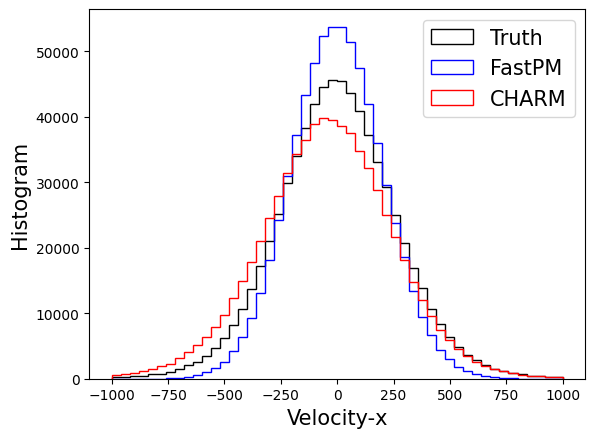

In [16]:
pl.figure()
_ = pl.hist(vel_h_truth[:,2], bins=50, range=(-1000,1000),histtype='step', color='k', label='Truth')
_ = pl.hist(vz_eval_interp_l, range=(-1000,1000), bins=50, histtype='step', color='b', label='FastPM')
_ = pl.hist((vz_total_mock), bins=50, range=(-1000,1000), histtype='step', color='r', label='CHARM')
# _ = pl.hist((np.concatenate(vz_diff_mock)), bins=50, range=(-1000,1000), histtype='step', color='orange', label='CHARM')
# pl.yscale('log')
pl.legend(fontsize=15)
pl.xlabel('Velocity-x', fontsize=15)
pl.ylabel('Histogram', fontsize=15)




In [17]:
import redshift_space_library as RSL

# pos_orig = np.stack([np.concatenate(x_h_truth), np.concatenate(y_h_truth), np.concatenate(z_h_truth)], axis=1)
# pos_orig.shape
velx_orig = (vel_h_truth[:,0]).astype(np.float32)[:, None]
velx_pm = (vx_eval_interp_l).astype(np.float32)[:, None]
velx_charm = (vx_total_mock).astype(np.float32)[:, None]


# velx_orig = (vel_h_truth[:,1]).astype(np.float32)[:, None]
# velx_pm = (vy_eval_interp_l).astype(np.float32)[:, None]
# velx_charm = (vy_total_mock).astype(np.float32)[:, None]

# velx_orig = (vel_h_truth[:,2]).astype(np.float32)[:, None]
# velx_pm = (vz_eval_interp_l).astype(np.float32)[:, None]
# velx_charm = (vz_total_mock).astype(np.float32)[:, None]


# print(pos_orig.shape, velx_orig.shape, velx_pm.shape, velx_charm.shape)


pos_rsd_orig = np.copy(pos_h_truth).astype(np.float32)
pos_rsd_pm = np.copy(np.ascontiguousarray(pos_h_mock)).astype(np.float32)
pos_rsd_charm = np.copy(np.ascontiguousarray(pos_h_mock)).astype(np.float32)

BoxSize = 1000.
Hubble = fid_cosmo_val_all[2]*100.
redshift = 0.5
axis = 0


RSL.pos_redshift_space(pos_rsd_orig, velx_orig, BoxSize, Hubble, redshift, axis)
RSL.pos_redshift_space(pos_rsd_pm, velx_pm, BoxSize, Hubble, redshift, axis)
RSL.pos_redshift_space(pos_rsd_charm, velx_charm, BoxSize, Hubble, redshift, axis)





In [18]:
import Pk_library as PKL
import MAS_library as MASL
grid_Pk_full = 128
MAS = 'NGP'
threads = 10
mesh_orig = np.zeros((grid_Pk_full, grid_Pk_full, grid_Pk_full), dtype=np.float32)
MASL.MA(pos_rsd_orig.astype(np.float32), mesh_orig, 1000., MAS)
mesh_orig /= np.mean(mesh_orig, dtype=np.float64);  mesh_orig -= 1.0
Pk_orig_rsd = PKL.Pk(mesh_orig, 1000., axis=0, MAS=MAS, threads=threads, verbose=False)

mesh_pm = np.zeros((grid_Pk_full, grid_Pk_full, grid_Pk_full), dtype=np.float32)
MASL.MA(pos_rsd_pm.astype(np.float32), mesh_pm, 1000., MAS)
mesh_pm /= np.mean(mesh_pm, dtype=np.float64);  mesh_pm -= 1.0
Pk_pm_rsd = PKL.Pk(mesh_pm, 1000., axis=0, MAS=MAS, threads=threads, verbose=False)

mesh_charm = np.zeros((grid_Pk_full, grid_Pk_full, grid_Pk_full), dtype=np.float32)
MASL.MA(pos_rsd_charm.astype(np.float32), mesh_charm, 1000., MAS)
mesh_charm /= np.mean(mesh_charm, dtype=np.float64);  mesh_charm -= 1.0
Pk_charm_rsd = PKL.Pk(mesh_charm, 1000., axis=0, MAS=MAS, threads=threads, verbose=False)




In [19]:
import Pk_library as PKL
import MAS_library as MASL
grid_Pk_full = 128
MAS = 'NGP'
threads = 10
mesh_orig = np.zeros((grid_Pk_full, grid_Pk_full, grid_Pk_full), dtype=np.float32)
MASL.MA(pos_h_truth.astype(np.float32), mesh_orig, 1000., MAS)
mesh_orig /= np.mean(mesh_orig, dtype=np.float64);  mesh_orig -= 1.0
Pk_orig_real = PKL.Pk(mesh_orig, 1000., axis=0, MAS=MAS, threads=threads, verbose=False)

mesh_charm = np.zeros((grid_Pk_full, grid_Pk_full, grid_Pk_full), dtype=np.float32)
MASL.MA(pos_h_mock.astype(np.float32), mesh_charm, 1000., MAS)
mesh_charm /= np.mean(mesh_charm, dtype=np.float64);  mesh_charm -= 1.0
Pk_charm_real = PKL.Pk(mesh_charm, 1000., axis=0, MAS=MAS, threads=threads, verbose=False)




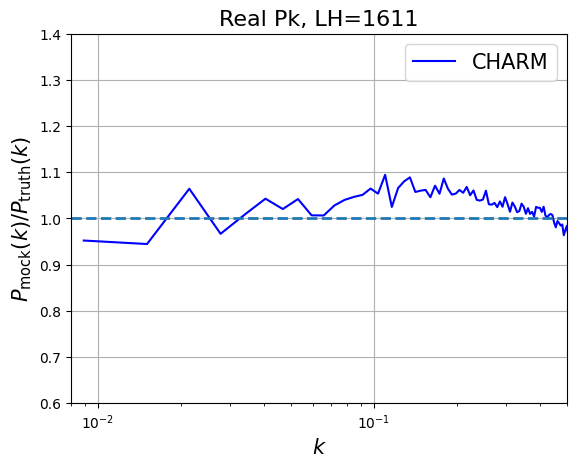

In [20]:
sdirf = '/mnt/home/spandey/ceph/CHARM/results/'
pl.figure()
# pl.plot(Pk_orig_rsd.k3D, Pk_pm_rsd.Pk[:,0]/Pk_orig_rsd.Pk[:,0], color='k', ls='-', alpha=1.0, label='FastPM')
pl.plot(Pk_orig_rsd.k3D, Pk_charm_real.Pk[:,0]/Pk_orig_real.Pk[:,0], color='b', ls='-', alpha=1.0, label='CHARM')
pl.axhline(1.0, ls='--', lw=2.0)
pl.xscale('log')
pl.ylim(0.6, 1.4)
pl.xlim(0.008, 0.5)
pl.xlabel(r'$k$', size=15)
pl.grid()
pl.legend(fontsize=15)
pl.ylabel(r'$P_{\rm mock}(k)/P_{\rm truth}(k)$', size=15)
pl.title(f'Real Pk, LH={test_id}', size=16)
pl.savefig(sdirf + f'NEW_real_Pk.png', dpi=300,bbox_inches='tight')




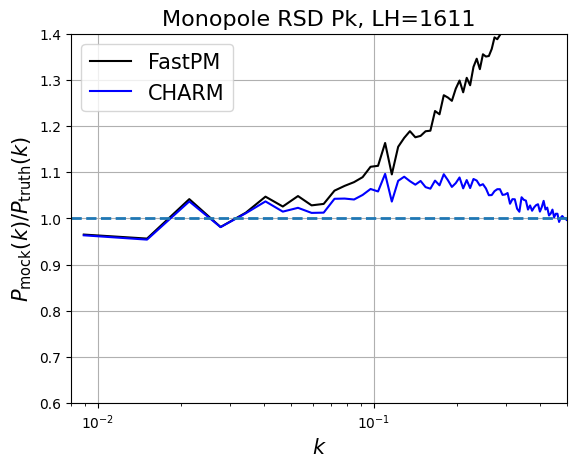

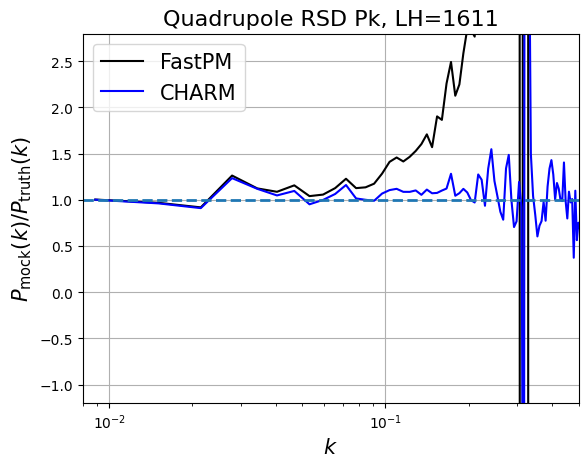

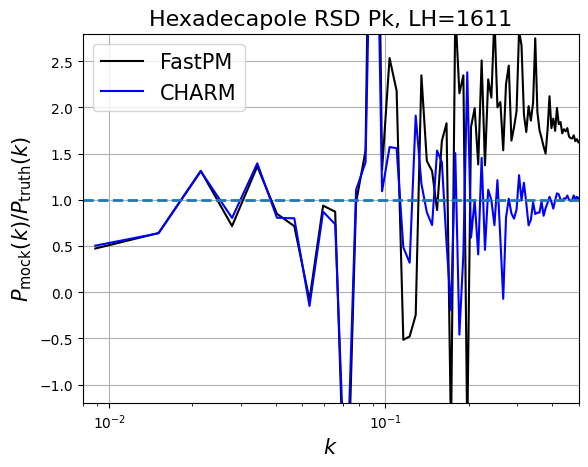

In [21]:
sdirf = '/mnt/home/spandey/ceph/CHARM/results/'
pl.figure()
pl.plot(Pk_orig_rsd.k3D, Pk_pm_rsd.Pk[:,0]/Pk_orig_rsd.Pk[:,0], color='k', ls='-', alpha=1.0, label='FastPM')
pl.plot(Pk_orig_rsd.k3D, Pk_charm_rsd.Pk[:,0]/Pk_orig_rsd.Pk[:,0], color='b', ls='-', alpha=1.0, label='CHARM')
pl.axhline(1.0, ls='--', lw=2.0)
pl.xscale('log')
pl.ylim(0.6, 1.4)
pl.xlim(0.008, 0.5)
pl.xlabel(r'$k$', size=15)
pl.grid()
pl.legend(fontsize=15)
pl.ylabel(r'$P_{\rm mock}(k)/P_{\rm truth}(k)$', size=15)
pl.title(f'Monopole RSD Pk, LH={test_id}', size=16)
pl.savefig(sdirf + f'NEW_monopole_Pk.png', dpi=300,bbox_inches='tight')

pl.figure()
pl.plot(Pk_orig_rsd.k3D, Pk_pm_rsd.Pk[:,1]/Pk_orig_rsd.Pk[:,1], color='k', ls='-', alpha=1.0, label='FastPM')
pl.plot(Pk_orig_rsd.k3D, Pk_charm_rsd.Pk[:,1]/Pk_orig_rsd.Pk[:,1], color='b', ls='-', alpha=1.0, label='CHARM')
pl.axhline(1.0, ls='--', lw=2.0)
pl.xscale('log')
pl.ylim(-1.2, 2.8)
pl.xlim(0.008, 0.5)
pl.xlabel(r'$k$', size=15)
pl.grid()
pl.legend(fontsize=15)
pl.ylabel(r'$P_{\rm mock}(k)/P_{\rm truth}(k)$', size=15)
pl.title(f'Quadrupole RSD Pk, LH={test_id}', size=16)
pl.savefig(sdirf + f'NEW_Quadrupole_Pk.png', dpi=300,bbox_inches='tight')

pl.figure()
pl.plot(Pk_orig_rsd.k3D, Pk_pm_rsd.Pk[:,2]/Pk_orig_rsd.Pk[:,2], color='k', ls='-', alpha=1.0, label='FastPM')
pl.plot(Pk_orig_rsd.k3D, Pk_charm_rsd.Pk[:,2]/Pk_orig_rsd.Pk[:,2], color='b', ls='-', alpha=1.0, label='CHARM')
pl.axhline(1.0, ls='--', lw=2.0)
pl.xscale('log')
pl.ylim(-1.2, 2.8)
pl.xlim(0.008, 0.5)
pl.xlabel(r'$k$', size=15)
pl.grid()
pl.legend(fontsize=15)
pl.ylabel(r'$P_{\rm mock}(k)/P_{\rm truth}(k)$', size=15)
pl.title(f'Hexadecapole RSD Pk, LH={test_id}', size=16)
pl.savefig(sdirf + f'NEW_Hexadecapole_Pk.png', dpi=300, bbox_inches='tight')









In [24]:
import pickle as pk
import matplotlib.pyplot as pl
%matplotlib inline
import numpy as np
test_id = 350
df = pk.load(open(f'/mnt/ceph/users/spandey/CHARM/data/halo_cats_charm_truth/halo_cat_pos_vel_LH_{test_id}.pk','rb'))
pos_rsdx_orig = df['pos_rsdx_truth']
pos_rsdx_mock = df['pos_rsdx_mock']
import Pk_library as PKL
import MAS_library as MASL
grid_Pk_full = 128
MAS = 'NGP'
threads = 10
mesh_orig = np.zeros((grid_Pk_full, grid_Pk_full, grid_Pk_full), dtype=np.float32)
MASL.MA(pos_rsdx_orig.astype(np.float32), mesh_orig, 1000., MAS)
mesh_orig /= np.mean(mesh_orig, dtype=np.float64);  mesh_orig -= 1.0
Pk_orig_rsd = PKL.Pk(mesh_orig, 1000., axis=0, MAS=MAS, threads=threads, verbose=False)


mesh_charm = np.zeros((grid_Pk_full, grid_Pk_full, grid_Pk_full), dtype=np.float32)
MASL.MA(pos_rsdx_mock.astype(np.float32), mesh_charm, 1000., MAS)
mesh_charm /= np.mean(mesh_charm, dtype=np.float64);  mesh_charm -= 1.0
Pk_charm_rsd = PKL.Pk(mesh_charm, 1000., axis=0, MAS=MAS, threads=threads, verbose=False)




Text(0.5, 1.0, 'Hexadecapole RSD Pk, LH=350')

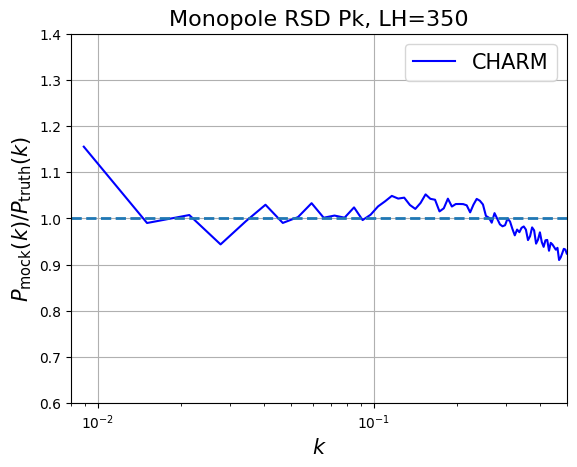

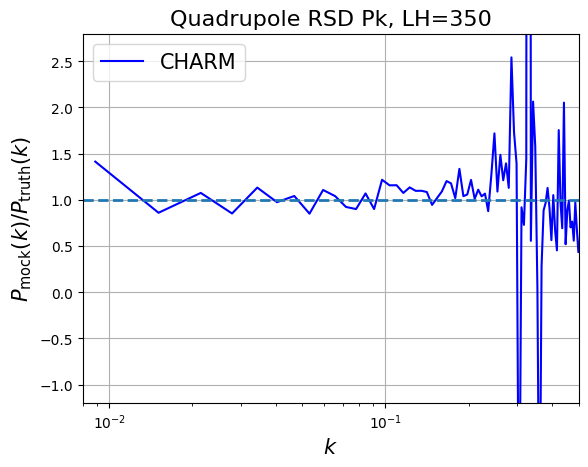

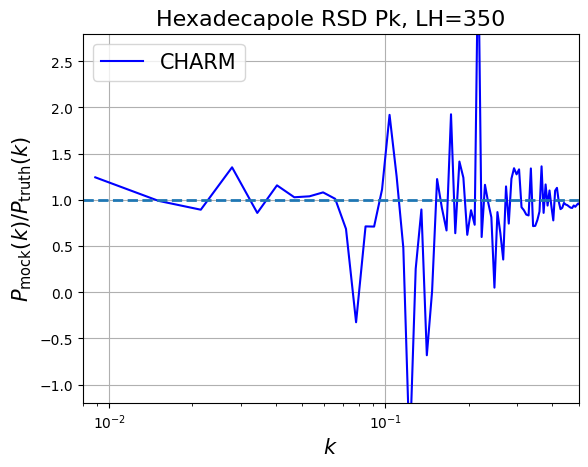

In [25]:
sdirf = '/mnt/home/spandey/ceph/CHARM/results/'
pl.figure()
# pl.plot(Pk_orig_rsd.k3D, Pk_pm_rsd.Pk[:,0]/Pk_orig_rsd.Pk[:,0], color='k', ls='-', alpha=1.0, label='FastPM')
pl.plot(Pk_orig_rsd.k3D, Pk_charm_rsd.Pk[:,0]/Pk_orig_rsd.Pk[:,0], color='b', ls='-', alpha=1.0, label='CHARM')
pl.axhline(1.0, ls='--', lw=2.0)
pl.xscale('log')
pl.ylim(0.6, 1.4)
pl.xlim(0.008, 0.5)
pl.xlabel(r'$k$', size=15)
pl.grid()
pl.legend(fontsize=15)
pl.ylabel(r'$P_{\rm mock}(k)/P_{\rm truth}(k)$', size=15)
pl.title(f'Monopole RSD Pk, LH={test_id}', size=16)
# pl.savefig(sdirf + f'NEW_monopole_Pk.png', dpi=300,bbox_inches='tight')

pl.figure()
# pl.plot(Pk_orig_rsd.k3D, Pk_pm_rsd.Pk[:,1]/Pk_orig_rsd.Pk[:,1], color='k', ls='-', alpha=1.0, label='FastPM')
pl.plot(Pk_orig_rsd.k3D, Pk_charm_rsd.Pk[:,1]/Pk_orig_rsd.Pk[:,1], color='b', ls='-', alpha=1.0, label='CHARM')
pl.axhline(1.0, ls='--', lw=2.0)
pl.xscale('log')
pl.ylim(-1.2, 2.8)
pl.xlim(0.008, 0.5)
pl.xlabel(r'$k$', size=15)
pl.grid()
pl.legend(fontsize=15)
pl.ylabel(r'$P_{\rm mock}(k)/P_{\rm truth}(k)$', size=15)
pl.title(f'Quadrupole RSD Pk, LH={test_id}', size=16)
# pl.savefig(sdirf + f'NEW_Quadrupole_Pk.png', dpi=300,bbox_inches='tight')

pl.figure()
# pl.plot(Pk_orig_rsd.k3D, Pk_pm_rsd.Pk[:,2]/Pk_orig_rsd.Pk[:,2], color='k', ls='-', alpha=1.0, label='FastPM')
pl.plot(Pk_orig_rsd.k3D, Pk_charm_rsd.Pk[:,2]/Pk_orig_rsd.Pk[:,2], color='b', ls='-', alpha=1.0, label='CHARM')
pl.axhline(1.0, ls='--', lw=2.0)
pl.xscale('log')
pl.ylim(-1.2, 2.8)
pl.xlim(0.008, 0.5)
pl.xlabel(r'$k$', size=15)
pl.grid()
pl.legend(fontsize=15)
pl.ylabel(r'$P_{\rm mock}(k)/P_{\rm truth}(k)$', size=15)
pl.title(f'Hexadecapole RSD Pk, LH={test_id}', size=16)
# pl.savefig(sdirf + f'NEW_Hexadecapole_Pk.png', dpi=300, bbox_inches='tight')










In [4]:
import os
from datetime import datetime

# Specify the path to your file
file_path = '/mnt/home/spandey/ceph/CHARM/data/halo_cats_charm_truth_nsubv_vel_10k/halo_cat_pos_vel_LH_799.pk'

# Get the last modified time of the file
last_modified_time = os.path.getmtime(file_path)

# Convert it to a readable format
last_modified_date = datetime.fromtimestamp(last_modified_time)

date_mod = last_modified_date.strftime('%d')


'29'